In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import cuml
    from cuml.ensemble import RandomForestRegressor as cuMLRandomForest
    from cuml.svm import SVR as cuMLSVR
    has_cuml = True
    print("cuML is installed => GPU acceleration available for RF & SVM.")
except ImportError:
    has_cuml = False
    print("cuML not found => falling back to scikit-learn CPU for RF & SVM.")

# scikit-learn
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor as SKLearnRandomForest
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR as SKLearnSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

from scipy.stats import mstats
from dateutil.relativedelta import relativedelta

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

cuML not found => falling back to scikit-learn CPU for RF & SVM.
PyTorch device: cuda


In [157]:
###############################################################################
# Utility Functions
###############################################################################
def drop_infs_and_align(X, y):
    """
    Utility to remove rows with Inf/NaN in X or y, returning aligned pairs.
    """
    X = X.replace([np.inf, -np.inf], np.nan)
    X, y = X.align(y, axis=0)  # ensure same index
    valid_mask = (~X.isna().any(axis=1)) & (~y.isna())
    return X[valid_mask], y[valid_mask]


def pcr_fit(X, y, n_components=3):
    """
    Fit Principal Component Regression (PCR) using up to n_components principal components.
    Returns the fitted scaler, PCA, and linear model.
    """
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    n_feat = X.shape[1]
    n_comps = min(n_feat, n_components)
    pca = PCA(n_components=n_comps, random_state=42)
    Xp = pca.fit_transform(Xs)

    lin = LinearRegression()
    lin.fit(Xp, y)
    return scaler, pca, lin

def pcr_predict(scaler, pca, lin, X):
    """
    Predict using the fitted PCR components and linear model.
    """
    Xs = scaler.transform(X)
    Xp = pca.transform(Xs)
    return lin.predict(Xp)

def remove_zero_variance_columns(df, columns):
    """
    Drops columns that have 0 or 1 unique value (i.e. no variance).
    Returns a list of columns that have >1 unique value.
    """
    keep_cols = []
    for c in columns:
        if c in df.columns:
            uniq_count = df[c].nunique(dropna=False)
            if uniq_count > 1:
                keep_cols.append(c)
    return keep_cols

def drop_infs_and_nans(df, col_list):
    """
    Drop rows with inf or NaN in any of the columns in col_list.
    Returns the cleaned dataframe.
    """
    df = df.copy()
    for c in col_list:
        df = df[df[c].notna()]
        df = df[np.isfinite(df[c])]
    return df

def select_top_signals_via_random_forest(
    df,
    signal_cols,
    target_col='excess_ret',
    date_col='yyyymm_return',
    train_frac=0.7,
    n_top=20,
    random_state=42
):
    """
    Select the top n_top signals based on feature_importances_ from a RandomForestRegressor.
    Splits by time up to train_frac fraction of dates, fits on that portion, then ranks signals.
    """
    if df.empty:
        print("[select_top_signals_via_random_forest] df empty => returning [].")
        return [], pd.DataFrame()

    # remove columns with zero variance
    signal_cols = remove_zero_variance_columns(df, signal_cols)
    if not signal_cols:
        print("[select_top_signals_via_random_forest] all signals zero-var => returning [].")
        return [], pd.DataFrame()

    col_list = signal_cols + [target_col, date_col]
    df = drop_infs_and_nans(df, col_list)
    if df.empty:
        print("[select_top_signals_via_random_forest] after drop => empty => returning [].")
        return [], pd.DataFrame()

    df.sort_values(date_col, inplace=True)
    unique_dates = df[date_col].unique()
    n_dates = len(unique_dates)
    if n_dates < 2:
        print("[select_top_signals_via_random_forest] not enough dates => returning [].")
        return [], pd.DataFrame()

    cut_idx = int(train_frac * n_dates)
    if cut_idx < 1:
        print("[select_top_signals_via_random_forest] train_frac => no train => returning [].")
        return [], pd.DataFrame()
    if cut_idx >= n_dates:
        print("[select_top_signals_via_random_forest] train_frac => no test => but okay for feature selection.")
        cut_idx = n_dates - 1

    cutoff_dt = unique_dates[cut_idx - 1]
    df_train = df[df[date_col] <= cutoff_dt].copy()
    if df_train.empty:
        print("[select_top_signals_via_random_forest] train empty => returning [].")
        return [], pd.DataFrame()

    X_train = df_train[signal_cols].values
    y_train = df_train[target_col].values

    rf = SKLearnRandomForest(
        n_estimators=100,
        max_features='sqrt',
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    idx_sorted = np.argsort(importances)[::-1]
    sorted_feats = [signal_cols[i] for i in idx_sorted]
    sorted_importances = importances[idx_sorted]

    df_imp = pd.DataFrame({'signal': sorted_feats, 'importance': sorted_importances})
    top_signals = sorted_feats[:n_top]
    
    print("\n=== RandomForest Feature Selection ===")
    print(f" => top {n_top} signals (train_frac={train_frac}):")
    print(df_imp.head(n_top).to_string(index=False))
    
    return top_signals, df_imp

In [159]:
###############################################################################
# 1) DATA LOADING & PRE-PROCESSING
###############################################################################
crsp_fp = 'data/crspm_and_predictors.csv'
df_crsp = pd.read_csv(crsp_fp)
df_crsp.rename(columns={'yyyymm': 'signal_month'}, inplace=True)
df_crsp['signal_month'] = pd.to_datetime(df_crsp['signal_month'].astype(str), format='%Y%m')

# SHIFT next-month returns (makes ret_decimal the forward return for t->t+1)
df_crsp['yyyymm_return'] = df_crsp['signal_month'].apply(lambda d: d + relativedelta(months=1))
df_crsp['ret_decimal'] = df_crsp['ret'] / 100.0

# Load T-Bill and merge
tbill_fp = 'data/TB3MS.csv'
df_tbill = pd.read_csv(tbill_fp)
df_tbill.rename(columns={'date': 'observation_date'}, inplace=True)
df_tbill['observation_date'] = pd.to_datetime(df_tbill['observation_date'])
df_tbill.rename(columns={'observation_date': 'yyyymm_return'}, inplace=True)

df_merged = pd.merge(
    df_crsp,
    df_tbill[['yyyymm_return','TB3MS']],
    how='left',
    on='yyyymm_return'
)

# monthly risk-free => decimal
df_merged['RF_monthly'] = (df_merged['TB3MS'] / 100.0) / 12.0
df_merged['excess_ret'] = df_merged['ret_decimal'] - df_merged['RF_monthly']

# Market cap from log(Size)
df_merged['mkt_cap'] = np.exp(df_merged['Size'])

# Drop missing essential data
df_merged.dropna(subset=['mkt_cap','ret_decimal'], inplace=True)
df_merged.sort_values(['signal_month','permno'], inplace=True)
print("After shifting returns & merging T-bill, shape:", df_merged.shape)

# Build value-weighted market factor
df_merged['total_mktcap'] = df_merged.groupby('signal_month')['mkt_cap'].transform('sum')
df_merged['weight'] = df_merged['mkt_cap'] / df_merged['total_mktcap']
df_merged['weighted_ret'] = df_merged['weight'] * df_merged['ret_decimal']

df_market = df_merged.groupby('signal_month', as_index=False)['weighted_ret'].sum()
df_market.rename(columns={'weighted_ret': 'market_ret'}, inplace=True)

df_market = pd.merge(
    df_market,
    df_merged[['signal_month','RF_monthly']].drop_duplicates(),
    on='signal_month',
    how='left'
)
df_market['mkt_excess_ret'] = df_market['market_ret'] - df_market['RF_monthly']

# ----------------------------------------------------------------------------
# fix LAG the market's forward return so no lookahead:
# ----------------------------------------------------------------------------
df_market.sort_values('signal_month', inplace=True)
df_market['mkt_excess_ret_lag1'] = df_market['mkt_excess_ret'].shift(1)
df_market.drop(columns=['mkt_excess_ret'], inplace=True)
df_market.rename(columns={'mkt_excess_ret_lag1': 'mkt_excess_ret'}, inplace=True)

df_final = pd.merge(
    df_merged,
    df_market[['signal_month','mkt_excess_ret']],
    on='signal_month',
    how='left'
)
df_final.dropna(subset=['excess_ret','mkt_excess_ret'], inplace=True)
print("Final dataset shape:", df_final.shape)

After shifting returns & merging T-bill, shape: (4618691, 125)
Final dataset shape: (4617606, 129)


In [160]:
###############################################################################
# 2) CHOOSE PREDICTOR COLUMNS & (OPTIONAL) ADD MORE SIGNALS
###############################################################################
all_potential_signals = [
    'mkt_excess_ret',  # now lagged version
    'Size',
    'Beta',
    'Mom12m',
    'VolMkt',
    'BM'
]

signal_cols_available = [c for c in all_potential_signals if c in df_final.columns]

# Winsorize & standardize signals
for col in signal_cols_available:
    if pd.api.types.is_numeric_dtype(df_final[col]):
        df_final[col] = mstats.winsorize(df_final[col], (0.01, 0.01))
        mean_val = df_final[col].mean()
        std_val  = df_final[col].std()
        df_final[col] = (df_final[col] - mean_val)/(std_val + 1e-8)

# Also winsorize next-month returns (the target)
df_final['excess_ret'] = mstats.winsorize(df_final['excess_ret'], (0.01,0.01))

top_signals, df_importances = select_top_signals_via_random_forest(
    df=df_final.copy(),
    signal_cols=signal_cols_available,
    target_col='excess_ret',
    date_col='yyyymm_return',
    train_frac=0.7,
    n_top=20, 
    random_state=42
)

if not top_signals:
    print("No top signals found => defaulting to original signals!")
    predictor_cols = signal_cols_available
else:
    predictor_cols = top_signals


=== RandomForest Feature Selection ===
 => top 20 signals (train_frac=0.7):
        signal  importance
        VolMkt    0.181683
          Size    0.171213
mkt_excess_ret    0.168765
        Mom12m    0.168174
          Beta    0.162906
            BM    0.147259


In [163]:
###############################################################################
# 3) TIME SPLIT (80/20) by yyyymm_return
###############################################################################
df_final.sort_values('yyyymm_return', inplace=True)
unique_dates = df_final['yyyymm_return'].unique()
n_months = len(unique_dates)
cutoff_idx = int(0.8 * n_months)
if cutoff_idx < 1:
    raise ValueError("Not enough months in your dataset for an 80/20 split!")
cutoff_dt = unique_dates[cutoff_idx]

df_train = df_final[df_final['yyyymm_return'] < cutoff_dt].copy()
df_test  = df_final[df_final['yyyymm_return'] >= cutoff_dt].copy()

X_train = df_train[predictor_cols]
y_train = df_train['excess_ret']
X_test  = df_test[predictor_cols]
y_test  = df_test['excess_ret']

print("\nUsing top signals:", predictor_cols)
print("Train range:", df_train['yyyymm_return'].min(), "->", df_train['yyyymm_return'].max())
print("Test  range:", df_test['yyyymm_return'].min(), "->", df_test['yyyymm_return'].max())
print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)



Using top signals: ['VolMkt', 'Size', 'mkt_excess_ret', 'Mom12m', 'Beta', 'BM']
Train range: 1960-03-01 00:00:00 -> 2012-01-01 00:00:00
Test  range: 2012-02-01 00:00:00 -> 2025-01-01 00:00:00
Train shape: (3406430, 129) | Test shape: (1211176, 129)


In [165]:
###############################################################################
# PyTorch MLP
###############################################################################
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes=[64, 64], activation=nn.ReLU):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(activation())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))  # final output layer for regression
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_mlp(
    X_train, y_train, X_val,
    device,
    hidden_sizes=(64, 64),
    epochs=20, lr=1e-3, batch_size=128, verbose=False
):
    X_torch = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_torch = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
    model = MLP(X_train.shape[1], hidden_sizes=hidden_sizes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    n_samples = X_torch.size(0)
    steps_per_epoch = (n_samples + batch_size - 1) // batch_size

    for ep in range(epochs):
        # Shuffle data each epoch
        perm_idx = torch.randperm(n_samples)
        X_torch = X_torch[perm_idx]
        y_torch = y_torch[perm_idx]

        running_loss = 0.0
        for i in range(steps_per_epoch):
            start = i * batch_size
            end = start + batch_size
            xb = X_torch[start:end]
            yb = y_torch[start:end]

            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if verbose and (ep + 1) % 5 == 0:
            print(f"Epoch {ep+1}/{epochs}, Loss={running_loss/steps_per_epoch:.4f}")

    X_val_torch = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    with torch.no_grad():
        y_val_pred = model(X_val_torch).cpu().numpy().ravel()
    return model, y_val_pred


In [167]:
###############################################################################
# 4) FIT MULTIPLE MODELS & COLLECT RESULTS
###############################################################################
results = {}
predictions = {}

###############################################################################
# (A) CAPM
###############################################################################
print("[CAPM] => fitting model...")

X_capm_train, y_capm_train = drop_infs_and_align(
    df_train[['mkt_excess_ret']],  # numeric only
    df_train['excess_ret']
)
capm_model = LinearRegression()
capm_model.fit(X_capm_train, y_capm_train)

X_capm_test_aligned, y_capm_test_aligned = drop_infs_and_align(
    df_test[['mkt_excess_ret']],  # numeric only
    df_test['excess_ret']
)
y_capm_pred = capm_model.predict(X_capm_test_aligned)
capm_r2 = r2_score(y_capm_test_aligned, y_capm_pred)
results['CAPM'] = capm_r2
predictions['CAPM'] = (y_capm_pred, y_capm_test_aligned)
print(f"[CAPM] => done. R^2 = {capm_r2:.4f}\n")

###############################################################################
# (B) Linear (OLS)
###############################################################################
print("[Linear] => fitting model...")

X_tr_lin, y_tr_lin = drop_infs_and_align(
    # Use errors='ignore' so no error if 'yyyymm_return' doesn't exist
    X_train.drop(columns=['yyyymm_return'], errors='ignore'),  
    y_train
)
lin_model = LinearRegression()
lin_model.fit(X_tr_lin, y_tr_lin)

X_te_lin_aligned, y_te_lin_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'),
    y_test
)
y_lin = lin_model.predict(X_te_lin_aligned)
lin_r2 = r2_score(y_te_lin_aligned, y_lin)
results['Linear'] = lin_r2
predictions['Linear'] = (y_lin, y_te_lin_aligned)
print(f"[Linear] => done. R^2 = {lin_r2:.4f}\n")

###############################################################################
# (C) Polynomial(2)
###############################################################################
print("[Polynomial(2)] => fitting model...")
poly = PolynomialFeatures(degree=2, include_bias=False)

X_tr_poly, y_tr_poly = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
X_tr_poly_ = poly.fit_transform(X_tr_poly)
poly_model = LinearRegression()
poly_model.fit(X_tr_poly_, y_tr_poly)

X_te_poly_aligned, y_te_poly_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
X_te_poly_ = poly.transform(X_te_poly_aligned)
y_poly = poly_model.predict(X_te_poly_)
poly_r2 = r2_score(y_te_poly_aligned, y_poly)
results['Polynomial(2)'] = poly_r2
predictions['Polynomial(2)'] = (y_poly, y_te_poly_aligned)
print(f"[Polynomial(2)] => done. R^2 = {poly_r2:.4f}\n")

###############################################################################
# (D) PCR
###############################################################################
print("[PCR] => fitting model...")
X_tr_pcr, y_tr_pcr = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
scaler_pcr, pca_pcr, lin_pcr = pcr_fit(X_tr_pcr, y_tr_pcr, n_components=3)

X_te_pcr_aligned, y_te_pcr_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
y_pcr = pcr_predict(scaler_pcr, pca_pcr, lin_pcr, X_te_pcr_aligned)
pcr_r2 = r2_score(y_te_pcr_aligned, y_pcr)
results['PCR'] = pcr_r2
predictions['PCR'] = (y_pcr, y_te_pcr_aligned)
print(f"[PCR] => done. R^2 = {pcr_r2:.4f}\n")

###############################################################################
# (E) Lasso
###############################################################################
print("[Lasso] => fitting model...")
X_tr_lasso, y_tr_lasso = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
lasso_model = LassoCV(cv=5, random_state=42)
lasso_model.fit(X_tr_lasso, y_tr_lasso)

X_te_lasso_aligned, y_te_lasso_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
y_lasso = lasso_model.predict(X_te_lasso_aligned)
lasso_r2 = r2_score(y_te_lasso_aligned, y_lasso)
results['LASSO'] = lasso_r2
predictions['LASSO'] = (y_lasso, y_te_lasso_aligned)
print(f"[Lasso] => done. R^2 = {lasso_r2:.4f} | alpha_={lasso_model.alpha_}\n")

###############################################################################
# (F) ElasticNet
###############################################################################
print("[ElasticNet] => fitting model...")
X_tr_en, y_tr_en = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
en_model = ElasticNetCV(cv=5, random_state=42)
en_model.fit(X_tr_en, y_tr_en)

X_te_en_aligned, y_te_en_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
y_en = en_model.predict(X_te_en_aligned)
en_r2 = r2_score(y_te_en_aligned, y_en)
results['ElasticNet'] = en_r2
predictions['ElasticNet'] = (y_en, y_te_en_aligned)
print(f"[ElasticNet] => done. R^2 = {en_r2:.4f} | alpha_={en_model.alpha_} | l1_ratio_={en_model.l1_ratio_}\n")

###############################################################################
# (G) RandomForest
###############################################################################
print("[RandomForest] => fitting model...")
X_tr_rf, y_tr_rf = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)

if has_cuml and device.type == 'cuda':
    print(" -> Using cuML GPU-based RandomForest...")
    rf_model = cuMLRandomForest(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=50,
        random_state=42
    )
    rf_model.fit(X_tr_rf.astype(np.float32), y_tr_rf.astype(np.float32))

    X_te_rf_aligned, y_te_rf_aligned = drop_infs_and_align(
        X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
        y_test
    )
    y_rf_gpu = rf_model.predict(X_te_rf_aligned.astype(np.float32))
    y_rf_gpu = y_rf_gpu.get() if hasattr(y_rf_gpu, 'get') else y_rf_gpu
    rf_r2 = r2_score(y_te_rf_aligned, y_rf_gpu)
    results['RandomForest(GPU)'] = rf_r2
    predictions['RandomForest(GPU)'] = (y_rf_gpu, y_te_rf_aligned)
    print(f"[RandomForest GPU] => done. R^2 = {rf_r2:.4f}\n")
else:
    print(" -> Using scikit-learn CPU-based RandomForest...")
    rf_model = SKLearnRandomForest(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=50,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_tr_rf, y_tr_rf)

    X_te_rf_aligned, y_te_rf_aligned = drop_infs_and_align(
        X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
        y_test
    )
    y_rf = rf_model.predict(X_te_rf_aligned)
    rf_r2 = r2_score(y_te_rf_aligned, y_rf)
    results['RandomForest'] = rf_r2
    predictions['RandomForest'] = (y_rf, y_te_rf_aligned)
    print(f"[RandomForest CPU] => done. R^2 = {rf_r2:.4f}\n")

###############################################################################
# (H) DecisionTree
###############################################################################
print("[DecisionTree] => fitting model...")
X_tr_dt, y_tr_dt = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=50,
    random_state=42
)
dt_model.fit(X_tr_dt, y_tr_dt)

X_te_dt_aligned, y_te_dt_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
y_dt = dt_model.predict(X_te_dt_aligned)
dt_r2 = r2_score(y_te_dt_aligned, y_dt)
results['DecisionTree'] = dt_r2
predictions['DecisionTree'] = (y_dt, y_te_dt_aligned)
print(f"[DecisionTree] => done. R^2 = {dt_r2:.4f}\n")

###############################################################################
# (I) PLS
###############################################################################
print("[PLS] => fitting model...")
X_tr_pls, y_tr_pls = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
pls_model = PLSRegression(n_components=3)
pls_model.fit(X_tr_pls, y_tr_pls)

X_te_pls_aligned, y_te_pls_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
y_pls = pls_model.predict(X_te_pls_aligned).ravel()
pls_r2 = r2_score(y_te_pls_aligned, y_pls)
results['PLS'] = pls_r2
predictions['PLS'] = (y_pls, y_te_pls_aligned)
print(f"[PLS] => done. R^2 = {pls_r2:.4f}\n")

###############################################################################
# (J) NeuralNet
###############################################################################
print("[NeuralNet] => training model...")
X_tr_mlp, y_tr_mlp = drop_infs_and_align(
    X_train.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_train
)
X_te_mlp_aligned, y_te_mlp_aligned = drop_infs_and_align(
    X_test.drop(columns=['yyyymm_return'], errors='ignore'), 
    y_test
)
mlp_model, y_mlp_pred = train_mlp(
    X_train=X_tr_mlp,
    y_train=y_tr_mlp,
    X_val=X_te_mlp_aligned,
    device=device,
    hidden_sizes=(64, 64),
    epochs=20,
    lr=1e-3,
    batch_size=256,
    verbose=False
)
mlp_r2 = r2_score(y_te_mlp_aligned, y_mlp_pred)
results['NeuralNet'] = mlp_r2
predictions['NeuralNet'] = (y_mlp_pred, y_te_mlp_aligned)
print(f"[NeuralNet] => done. R^2 = {mlp_r2:.4f}\n")


[CAPM] => fitting model...
[CAPM] => done. R^2 = -0.0026

[Linear] => fitting model...
[Linear] => done. R^2 = 0.0140

[Polynomial(2)] => fitting model...
[Polynomial(2)] => done. R^2 = 0.0243

[PCR] => fitting model...
[PCR] => done. R^2 = 0.0156

[Lasso] => fitting model...
[Lasso] => done. R^2 = 0.0173 | alpha_=0.00044241659966353904

[ElasticNet] => fitting model...
[ElasticNet] => done. R^2 = 0.0174 | alpha_=0.0008848331993270782 | l1_ratio_=0.5

[RandomForest] => fitting model...
 -> Using scikit-learn CPU-based RandomForest...
[RandomForest CPU] => done. R^2 = 0.0499

[DecisionTree] => fitting model...
[DecisionTree] => done. R^2 = 0.0261

[PLS] => fitting model...
[PLS] => done. R^2 = 0.0132

[NeuralNet] => training model...
[NeuralNet] => done. R^2 = 0.0297




=== Out-of-Sample R^2 (Monthly Data) ===
CAPM: -0.0026
Linear: 0.0140
Polynomial(2): 0.0243
PCR: 0.0156
LASSO: 0.0173
ElasticNet: 0.0174
RandomForest: 0.0499
DecisionTree: 0.0261
PLS: 0.0132
NeuralNet: 0.0297


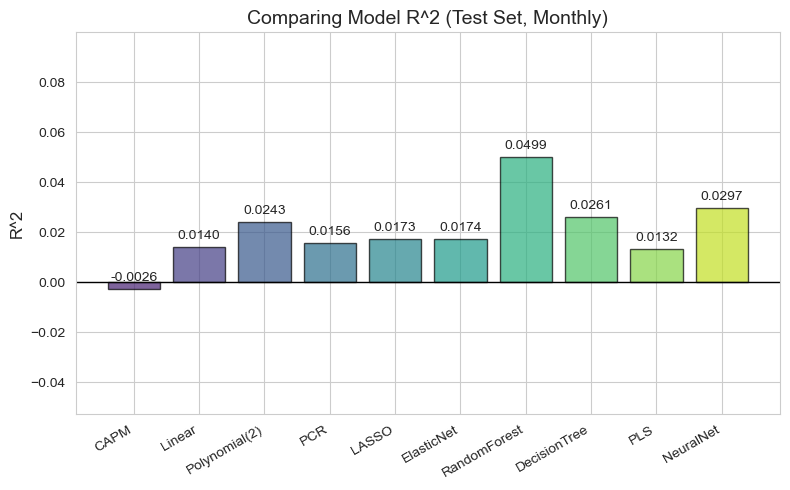

In [169]:
###############################################################################
# 5) REPORT MODEL PERFORMANCE
###############################################################################
print("\n=== Out-of-Sample R^2 (Monthly Data) ===")
for name, r2v in results.items():
    print(f"{name}: {r2v:.4f}")

# Enhanced Bar Plot
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")   # gives a background grid

names = list(results.keys())
vals = list(results.values())

# Create a color palette (e.g., one distinct color per bar)
colors = sns.color_palette("viridis", len(vals))

bars = plt.bar(names, vals, color=colors, alpha=0.7, edgecolor='black')

plt.title("Comparing Model R^2 (Test Set, Monthly)", fontsize=14)
plt.ylabel("R^2", fontsize=12)

# Optionally, add a horizontal line at R^2 = 0
plt.axhline(y=0, color='black', linewidth=1)

# Label each bar with its R^2 value
for bar, val in zip(bars, vals):
    # Coordinates for text above each bar
    x_pos = bar.get_x() + bar.get_width()/2
    y_pos = val + 0.002
    plt.text(x_pos, y_pos, f"{val:.4f}", ha='center', va='bottom', fontsize=10)

# Adjust y-limits for a bit of extra space
plt.ylim([min(vals) - 0.05, max(vals) + 0.05])

# Tilt the x‐axis labels slightly for readability
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()



=== Out-of-Sample R^2 (Monthly Data) ===
CAPM: -0.0026
Linear: 0.0140
Polynomial(2): 0.0243
PCR: 0.0156
LASSO: 0.0173
ElasticNet: 0.0174
RandomForest: 0.0499
DecisionTree: 0.0261
PLS: 0.0132
NeuralNet: 0.0297


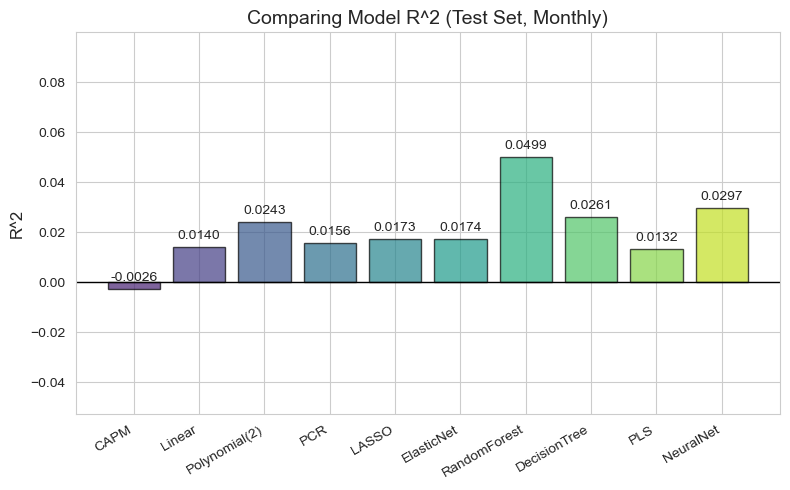


=== Out-of-Sample MSE (Monthly Data) ===
CAPM: 0.015278
Linear: 0.019530
Polynomial(2): 0.019326
PCR: 0.019498
LASSO: 0.019464
ElasticNet: 0.019462
RandomForest: 0.018818
DecisionTree: 0.019290
PLS: 0.019546
NeuralNet: 0.019218


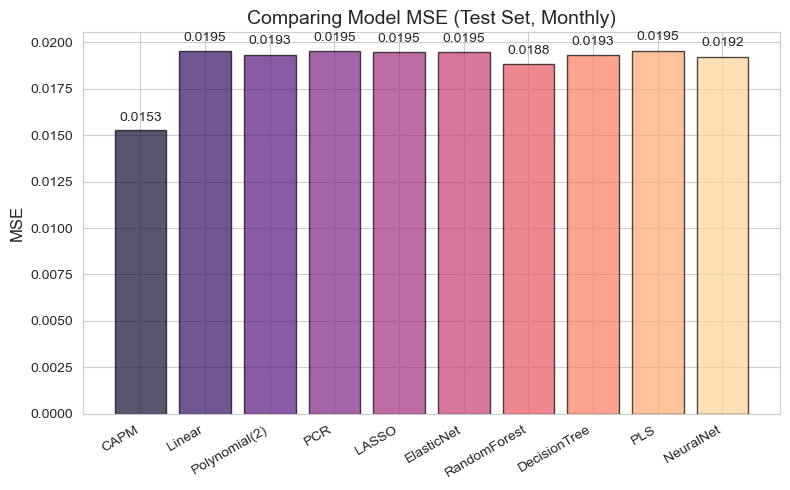

In [171]:
from sklearn.metrics import mean_squared_error

###############################################################################
# 5) REPORT MODEL PERFORMANCE - R^2 
###############################################################################
print("\n=== Out-of-Sample R^2 (Monthly Data) ===")
for name, r2v in results.items():
    print(f"{name}: {r2v:.4f}")

# Enhanced Bar Plot for R^2
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")   # gives a background grid

names = list(results.keys())
vals = list(results.values())

# Create a color palette (e.g., one distinct color per bar)
colors = sns.color_palette("viridis", len(vals))

bars = plt.bar(names, vals, color=colors, alpha=0.7, edgecolor='black')

plt.title("Comparing Model R^2 (Test Set, Monthly)", fontsize=14)
plt.ylabel("R^2", fontsize=12)

# Optionally, add a horizontal line at R^2 = 0
plt.axhline(y=0, color='black', linewidth=1)

# Label each bar with its R^2 value
for bar, val in zip(bars, vals):
    x_pos = bar.get_x() + bar.get_width()/2
    y_pos = val + 0.002
    plt.text(x_pos, y_pos, f"{val:.4f}", ha='center', va='bottom', fontsize=10)

# Adjust y-limits for a bit of extra space
plt.ylim([min(vals) - 0.05, max(vals) + 0.05])

# Tilt the x‐axis labels slightly for readability
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

###############################################################################
# 6) COMPUTE AND REPORT MSE
###############################################################################
mse_results = {}
for name, (y_pred, y_true) in predictions.items():
    mse_results[name] = mean_squared_error(y_true, y_pred)

# Print MSE results
print("\n=== Out-of-Sample MSE (Monthly Data) ===")
for name, mse_val in mse_results.items():
    print(f"{name}: {mse_val:.6f}")

# Bar Plot for MSE
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

names_mse = list(mse_results.keys())
vals_mse = list(mse_results.values())

# Create a different color palette, if desired
colors_mse = sns.color_palette("magma", len(vals_mse))

bars_mse = plt.bar(names_mse, vals_mse, color=colors_mse, alpha=0.7, edgecolor='black')

plt.title("Comparing Model MSE (Test Set, Monthly)", fontsize=14)
plt.ylabel("MSE", fontsize=12)

# Annotate each bar with its MSE value
for bar, val in zip(bars_mse, vals_mse):
    x_pos = bar.get_x() + bar.get_width()/2
    # Slight offset so the text doesn't overlap the bar edge
    y_pos = val + (0.02 * val if val != 0 else 0.001)
    plt.text(x_pos, y_pos, f"{val:.4f}", ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


Cutting off outliers at [1%, 99%] => x in [-0.2194, 0.1982]


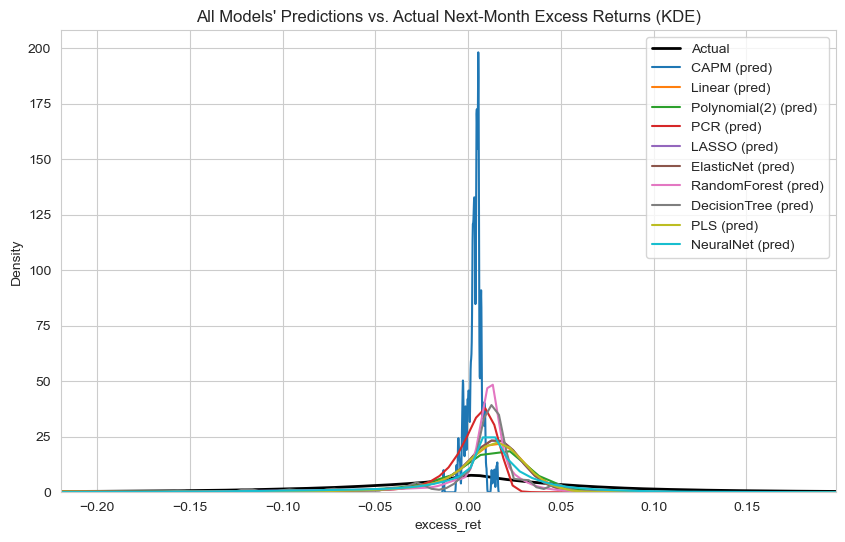

In [173]:
###############################################################################
# 6) SUPERIMPOSE ALL MODEL DISTRIBUTIONS ON ONE GRAPH
###############################################################################
plt.figure()
sns.kdeplot(y_test, label='Actual', color='black', linewidth=2)

# Flatten all predictions + actual for outlier cut
all_data = [y_test.values]
for (y_pred, _) in predictions.values():
    all_data.append(y_pred)
all_data = np.concatenate(all_data)
lower_cut, upper_cut = np.percentile(all_data, [1, 99])
print(f"Cutting off outliers at [1%, 99%] => x in [{lower_cut:.4f}, {upper_cut:.4f}]")

for model_name, (y_pred, _) in predictions.items():
    sns.kdeplot(y_pred, label=f"{model_name} (pred)")

plt.title("All Models' Predictions vs. Actual Next-Month Excess Returns (KDE)")
plt.xlim(lower_cut, upper_cut)
plt.legend()
plt.show()

In [181]:
###############################################################################
# 5) LONG–SHORT SHARPE RATIO FOR EACH MODEL
###############################################################################
def compute_long_short_sharpe(df, preds, date_col='yyyymm_return', realized_col='excess_ret', n_groups=10):
    df_temp = df.copy()
    df_temp['pred'] = preds
    
    monthly_ls_returns = []
    grouped = df_temp.groupby(date_col, group_keys=False)
    for gdate, grp in grouped:
        grp = grp.copy()
        
        # Rank by predicted return within each month
        grp['decile'] = pd.qcut(grp['pred'].rank(method='first'), n_groups, labels=False)
        
        # Top and bottom deciles
        top = grp[grp['decile'] == (n_groups - 1)][realized_col].mean()
        bot = grp[grp['decile'] == 0][realized_col].mean()
        
        ls_return = top - bot  # long–short monthly return
        monthly_ls_returns.append(ls_return)
    
    monthly_ls_returns = np.array(monthly_ls_returns)
    
    # Basic Sharpe: mean / std, annualized by sqrt(12)
    sharpe_monthly = monthly_ls_returns.mean() / monthly_ls_returns.std()
    sharpe_annual = sharpe_monthly * np.sqrt(12)
    
    return sharpe_annual, monthly_ls_returns


# Dictionary to store Sharpe Ratios
sharpe_ratios = {}

# We'll compute a long–short Sharpe for each model in the `predictions` dictionary
for model_name, (y_pred, y_true) in predictions.items():
    # Align df_test on the same index as y_true if needed
    # (Assuming here that df_test already has matching indices for y_true)
    df_test_aligned = df_test.loc[y_true.index].copy()
    
    # Compute the long–short Sharpe
    sr_annual, ls_returns = compute_long_short_sharpe(
        df=df_test_aligned,
        preds=y_pred,
        date_col='yyyymm_return',
        realized_col='excess_ret'
    )
    sharpe_ratios[model_name] = sr_annual

# Print results
print("Annualized Long–Short Sharpe Ratios:")
for m, sr in sharpe_ratios.items():
    print(f"  {m}: {sr:.4f}")


Annualized Long–Short Sharpe Ratios:
  CAPM: -0.8753
  Linear: 4.6448
  Polynomial(2): 5.7759
  PCR: 1.9493
  LASSO: 4.5769
  ElasticNet: 4.5727
  RandomForest: 7.0612
  DecisionTree: 7.1099
  PLS: 4.6738
  NeuralNet: 7.2717
